### Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### CSV to Data Frame

<Axes: xlabel='Date'>

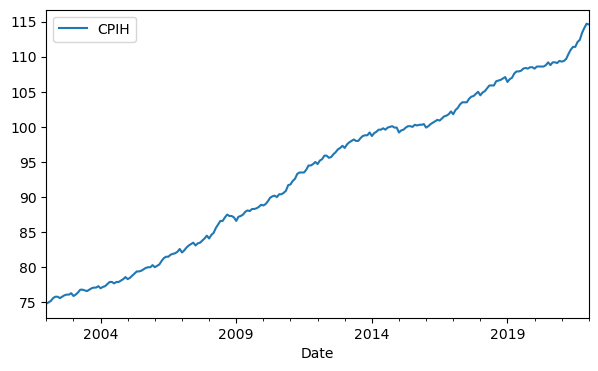

In [9]:
cpih_data = pd.read_csv("cpih_data.csv", index_col=0, parse_dates=True)
cpih_data.plot(figsize=(7, 4))

### ADF Test Functions

In [10]:
# Augmented Dickey-Fuller Test (NO TREND).
def adf_test(timeseries):
    print("NULL HYPOTHESIS: The series has a unit root.")
    print("Results of DF test:")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="c",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Augmented Dickey-Fuller Test + CONTINUOUS TREND (ct).
def adf_test_ct(timeseries):
    print("NULL HYPOTHESIS: The Series has a unit root.")
    print("Results of DF test (+ CT):")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="ct",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

#### KPSS Test Functions

In [11]:
def kpss_test(timeseries):
    print("NULL HYPOTHESIS: The process is trend stationary.")
    print("Results of KPSS test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Inducing Stationarity: First Difference + Seasonal Adjustments

In [12]:
cpih_diff1 = cpih_data.copy()
cpih_diff1["cpih_diff1"] = cpih_diff1["CPIH"] - cpih_diff1["CPIH"].shift(1)
cpih_diff1 = cpih_diff1.iloc[1:]

NULL HYPOTHESIS: The series has a unit root.
Results of DF test:
Test Statistic                  -4.929363
p-value                          0.000031
Lags Used                       11.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


NULL HYPOTHESIS: The process is trend stationary.
Results of KPSS test:
Test Statistic           0.147673
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/52/118zx6s92x5dv1www3l374100000gn/T/ipykernel_71975/3938655962.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


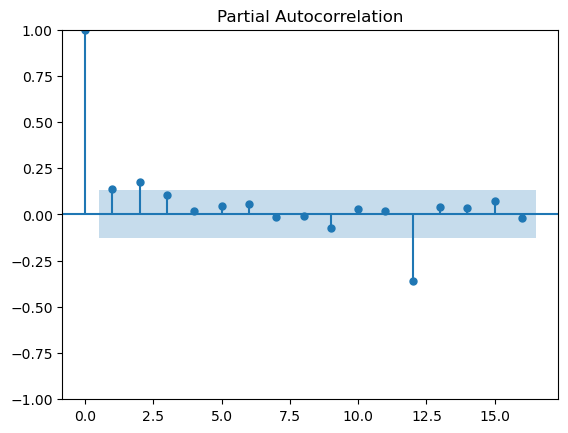

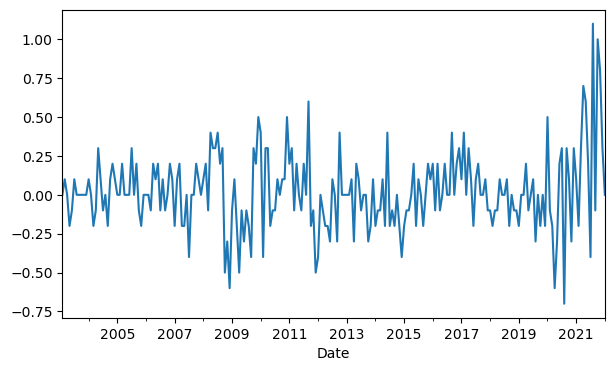

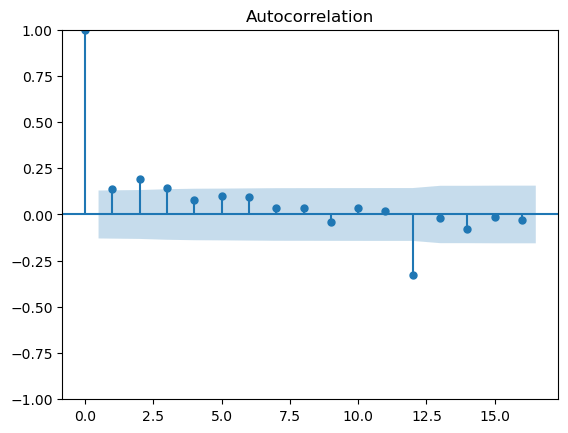

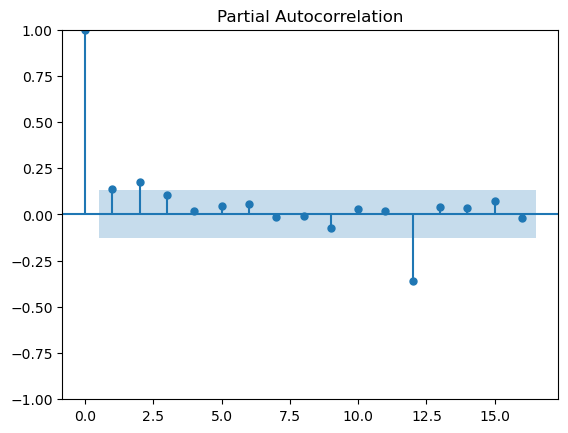

In [13]:
cpih_diff1_SA = cpih_diff1.copy()
cpih_diff1_SA["CPIH_diff1_SA"] = cpih_diff1_SA["cpih_diff1"] - cpih_diff1_SA["cpih_diff1"].shift(12) # 12 is the seasonal period.
cpih_diff1_SA = cpih_diff1_SA.iloc[12:]

cpih_diff1_SA_adf_score = adf_test(cpih_diff1_SA["CPIH_diff1_SA"])
print("\n")
cpih_diff1_SA_kpss_score = kpss_test(cpih_diff1_SA["CPIH_diff1_SA"])

cpih_diff1_SA["CPIH_diff1_SA"].plot(figsize=(7, 4))
plot_acf(cpih_diff1_SA["CPIH_diff1_SA"].values.squeeze(), lags=16)
plot_pacf(cpih_diff1_SA["CPIH_diff1_SA"].values.squeeze(), lags=16)

In [26]:
"""
MODEL SELECTION

Ignoring lag 12 (likely seasonal spike),
significant lags 1, 2, 3, 4 in ACF -------> MA(4)?
significant lags 1, 2, 3 in PACF   -------> AR(3)?

ARMA(4,3)? ARIMA(4,0,3)?

GPT suggestion of SARIMA(4,0,3)(1,0,1){12}?

Use AIC, BIC, SBIC information criterion for selection??

model = sm.tsa.SARIMAX(cpih_diff1_SA["CPIH_diff1_SA"], order=(3,0,4), seasonal_order=(1,0,1,12))
results = model.fit()

aic = results.aic
bic = results.bic

print(f"AIC: {aic}")
print(f"BIC: {bic}")

import statsmodels.tsa as sm


model = sm.statespace.SARIMAX(cpih_diff1_SA["CPIH_diff1_SA"], order=(3,0,4), seasonal_order=(1,0,1,12))
results = model.fit()

model = sm.tsa.statespace.SARIMAX(cpih_diff1_SA["CPIH_diff1_SA"], trend='c', order=(3,0,4), seasonal_order=(1,0,1,12))
results = model.fit(disp=False)
print(results.summary())
"""

model = sm.tsa.ARIMA(cpih_diff1_SA["CPIH_diff1_SA"], order=(0,0,1), trend="n")
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:          CPIH_diff1_SA   No. Observations:                  228
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  -3.328
Date:                Fri, 07 Jun 2024   AIC                             10.657
Time:                        14:01:56   BIC                             17.516
Sample:                    02-01-2003   HQIC                            13.424
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1082      0.047      2.282      0.022       0.015       0.201
sigma2         0.0603      0.004     16.387      0.000       0.053       0.067
Ljung-Box (L1) (Q):                   0.04   Jarque-

/Users/jonathannewman/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jonathannewman/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jonathannewman/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
